In [3]:
import os
import math
import sys

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Немного о ресурсах в Spark

Spark управляет ресурсами через Driver, а ресурсы - распределенные Executors.

`Executor` это рабочий процесс, который запускает индивидуальные заданий в общем Spark Job. Они запускаются с процессом, выполняют свою задачу и посылают результаты на `driver`. 

`Driver` это процесс осуществляющий контроль над запущенным Spark Job. Он конвертирует код в задачи и составляет расписание задач для `executors`.

Рабочий процесс, который они делают на основе вашего кода можно изобразить так:

- driver запрашивает ресурсы у cluster manager
- запускаются executors, если доступны выделенные ресурсы
- driver планирует работу и трансформирует ваш код в план выполнения
- executors выполняют задачу и отправляют отчет о своей работе на driver
- каждый процесс должен быть завершен и driver по нему должен получить результат (отчет), иначе процесс должен быть перезапущен driver'ом
- spark.stop() завершает работу и освобождает ресурсы.


## Расчет параметров для Spark

#### Выдумаем кластер

In [13]:
# установите параметры кластера

# сколько хотите задействовать excecutors 
# (это может быть любое число от 1 до +inf, это нужно для расчетов в качестве индексов)
max_executor = 300   

# количество узлов в кластере (запомним, что 1 Node = 1 Worker process)
# ед. - штук
nodes = 10
nodes = nodes - 1  

# количество процессоров на кластере (сумма по всем нодам) (в примере: вы будете использовать 1/3 от кластера)
# ед. - штук
cpu = 80
cpu = int((cpu - 1) / 3)

# количество ОЗУ на кластере (в примере: вы будете использовать 1/3 от кластера)
# ед. - мегабайт
memo = 200000000
memo = int((memo - 1024) / 3)

# установите коэффициент overhead памяти (здесь базовое значение)
overhead_coef = 0.1

# кол-во параллелизма - базовое количество партиций в RDD
parallelizm_per_core = 10

# фактор партиционирования в hdfs
partition_factor = 3


### Запомним!

Мы распеределяем ресурсы для Spark, надо учитывать, что Spark выполяет операции так:

ВАШ КОД -> CATALYST -> RDD -> DAG SCHEDULER -> MANAGER -> EXECUTOR

## Расчет по формулам

Общая практика, для нормального существования на кластере:

- быстрее -> больше CPU
- большие объекты -> больше RAM (**!NB!**)

**Большой объект не всегда большой. Что вы уже знаете про READ (?)**

In [14]:
# создаем DataFrame с установкой параметров (кол-во executors устанавливаем как нарастающее значение)
df = pd.DataFrame(dict(executors=np.arange(1, max_executor)))

# расчёт кол-ва памяти на 1 executor
# можно использовать формулу NUM_CORES * ((EXECUTOR_MEMORY + MEMORY_OVERHEAD) / EXECUTOR_CORES) (результат Гб на executor)
# но здесь ещё один метод рассчета
df['total_memo_per_executor'] = np.floor((memo / df.executors) * 0.9)

# overhead по стандарту 10% от executor
df['total_memooverhead_per_executor'] = df['total_memo_per_executor'] * 0.10

# остаток не используемой памяти на ноде
df['unused_memo_per_node'] = memo - (df.executors * df['total_memo_per_executor'])

# сколько займет процессоров
df['total_core_per_executor'] = np.floor(cpu / df.executors)

# остаток процессоров на ноде
df['unused_core_per_nodes'] = cpu - (df.executors * df['total_core_per_executor'])

# расчет памяти на executor
df['overhead_memo'] = (df['total_memo_per_executor'] * overhead_coef)
df['executor_memo'] = df['total_memo_per_executor'] - df['overhead_memo']

# кол-во процессор на executor
df['executor_cores'] = np.floor(cpu / df.executors)

# минус 1 для driver
df['executor_instance'] = (df.executors *df['executor_cores']) - 1 

# рассчитываем или меняем по коду в ручную (можно начать с 2 для parallelizm_per_core)
df['parallelism'] = df['executor_instance'] * df['executor_cores'] * parallelizm_per_core 
df['num_partitions'] = df['executor_instance'] * df['executor_cores'] * partition_factor

# % используемой памяти на кластере
df['used_memo_persentage'] = (1- ((df['overhead_memo'] + df['executor_memo']) / memo)) * 100
# % используемых процессоров на кластере
df['used_cpu_persentage'] = ((cpu - df['unused_core_per_nodes']) / cpu) * 100


df.head(100)


,executors,total_memo_per_executor,total_memooverhead_per_executor,unused_memo_per_node,total_core_per_executor,unused_core_per_nodes,overhead_memo,executor_memo,executor_cores,executor_instance,parallelism,num_partitions,used_memo_persentage,used_cpu_persentage
0,1,59999692.0,5999969.2,6666633.0,26.0,0.0,5999969.2,53999722.8,26.0,25.0,6500.0,1950.0,10.000001,100.000000
1,2,29999846.0,2999984.6,6666633.0,13.0,0.0,2999984.6,26999861.4,13.0,25.0,3250.0,975.0,55.000000,100.000000
2,3,19999897.0,1999989.7,6666634.0,8.0,2.0,1999989.7,17999907.3,8.0,23.0,1840.0,552.0,70.000001,92.307692
3,4,14999923.0,1499992.3,6666633.0,6.0,2.0,1499992.3,13499930.7,6.0,23.0,1380.0,414.0,77.500000,92.307692
4,5,11999938.0,1199993.8,6666635.0,5.0,1.0,1199993.8,10799944.2,5.0,24.0,1200.0,360.0,82.000001,96.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,624996.0,62499.6,6666709.0,0.0,26.0,62499.6,562496.4,0.0,-1.0,-0.0,-0.0,99.062501,0.000000
96,97,618553.0,61855.3,6666684.0,0.0,26.0,61855.3,556697.7,0.0,-1.0,-0.0,-0.0,99.072166,0.000000
97,98,612241.0,61224.1,6666707.0,0.0,26.0,61224.1,551016.9,0.0,-1.0,-0.0,-0.0,99.081634,0.000000
98,99,606057.0,60605.7,6666682.0,0.0,26.0,60605.7,545451.3,0.0,-1.0,-0.0,-0.0,99.090910,0.000000


<AxesSubplot:title={'center':'Распределение значений по параметрам'}>

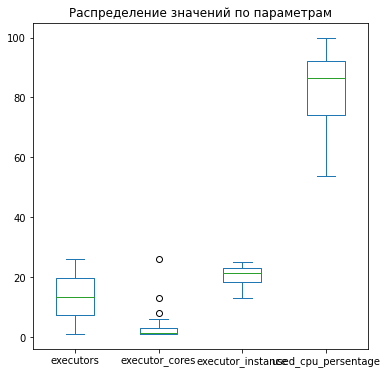

In [15]:
# посмотрим на графике распределения ресурсов
(df[(df['used_memo_persentage'] > 0)    & \
    (df['used_cpu_persentage'] > 0)     & \
    (df['used_memo_persentage'] <= 100) & \
    (df['used_cpu_persentage'] <= 100)  & \
    (df['executor_instance'] > 0)       & \
    (df['parallelism'] > 0)             & \
    (df['num_partitions'] > 0)          
    ])[['executors', 
        'executor_cores', 
        'executor_instance',
        'used_cpu_persentage'
       ]].plot(kind='box', figsize=(6,6), title='Распределение значений по параметрам')


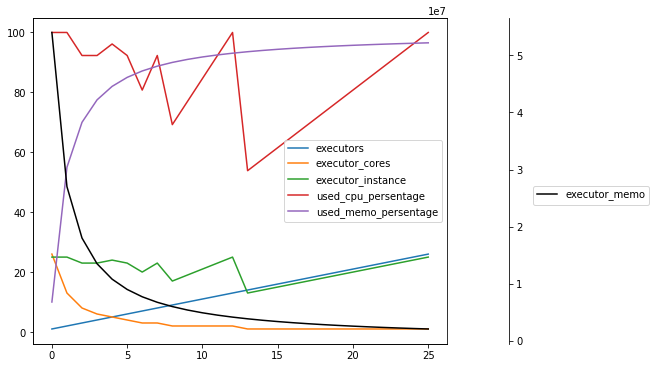

In [16]:
# посмотрим на графике распределения ресурсов
fig, ax = plt.subplots()
tdf1 = (df[(df['used_memo_persentage'] > 0)    & \
           (df['used_cpu_persentage'] > 0)     & \
           (df['used_memo_persentage'] <= 100) & \
           (df['used_cpu_persentage'] <= 100)  & \
           (df['executor_instance'] > 0)       & \
           (df['parallelism'] > 0)             & \
           (df['num_partitions'] > 0)          
            ])[['executors', 
                'executor_cores', 
                'executor_instance',
                'used_cpu_persentage',
                'used_memo_persentage'
               ]].plot(ax = ax,  figsize=(10, 6))

tdf2 = (df[(df['used_memo_persentage'] > 0)    & \
           (df['used_cpu_persentage'] > 0)     & \
           (df['used_memo_persentage'] <= 100) & \
           (df['used_cpu_persentage'] <= 100)  & \
           (df['executor_instance'] > 0)       & \
           (df['parallelism'] > 0)             & \
           (df['num_partitions'] > 0)          
            ])[[
                'executor_memo'
               ]]


ax2 = ax.twinx()
rspine = ax2.spines['right']
rspine.set_position(('axes', 1.15))
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
fig.subplots_adjust(right=0.7)

tdf2.plot(ax=ax2, color='black')


ax2.legend(bbox_to_anchor=(1.5, 0.5))


In [17]:
# установите количество используемой памяти и процессоров
# например: в расчете вы использовали 1/3 от доступных ресурсов (так как вас 3 человека на кластере)
# сделайте выбор всех доступных вам ресурсов

df_opt = df[(df['used_memo_persentage'] == df['used_memo_persentage'].max())]
df_opt.head()

# вы видите, что max() по ОЗУ превышает кол-во CPU и вы не можете использовать такие параметры


,executors,total_memo_per_executor,total_memooverhead_per_executor,unused_memo_per_node,total_core_per_executor,unused_core_per_nodes,overhead_memo,executor_memo,executor_cores,executor_instance,parallelism,num_partitions,used_memo_persentage,used_cpu_persentage
298,299,200667.0,20066.7,6666892.0,0.0,26.0,20066.7,180600.3,0.0,-1.0,-0.0,-0.0,99.698998,0.0


In [18]:
# сделаем выбор по другим фильтрам (чтобы получить нормальные параметры)
# executor_instance
# parallelism
# num_partitions
# установим максимальное использование выделенных ресурсов.

df_opt = df[(df['executor_instance'] > 0)       & \
            (df['parallelism'] > 0)             & \
            (df['num_partitions'] > 0)]

df_opt = df_opt[(df_opt['used_memo_persentage'] == df_opt['used_memo_persentage'].max())]
df_opt


,executors,total_memo_per_executor,total_memooverhead_per_executor,unused_memo_per_node,total_core_per_executor,unused_core_per_nodes,overhead_memo,executor_memo,executor_cores,executor_instance,parallelism,num_partitions,used_memo_persentage,used_cpu_persentage
25,26,2307680.0,230768.0,6666645.0,1.0,0.0,230768.0,2076912.0,1.0,25.0,250.0,75.0,96.538462,100.0


In [11]:
# запишем параметры в переменные
sparkYarnExecutorMemoryOverhead = "{}Mb".format(df_opt['overhead_memo'].astype('int').values[0])
sparkExecutorsMemory = "{}Mb".format(df_opt['executor_memo'].astype('int').values[0])
sparkDriverMemory = "{}Mb".format(df_opt['executor_memo'].astype('int').values[0])
sparkDriverMaxResultSize = "{}Mb".format(df_opt['executor_memo'].astype('int').values[0] if df_opt['executor_memo'].astype('int').values[0] <= 4080 else 4080)
sparkExecutorCores = "{}".format(df_opt['executor_cores'].astype('int').values[0])
sparkDriverCores = "{}".format(df_opt['executor_cores'].astype('int').values[0])
defParallelism = "{}".format(df_opt['parallelism'].astype('int').values[0])

In [12]:
sparkDriverMemory

'6843Mb'

In [37]:
# Добавим параметры 
# sparkDynamicAllocationEnabled при "true" будет динамическое выделение ресурсов на весь доступный объем
sparkDynamicAllocationEnabled = "true"
sparkShuffleServiceEnabled = "true"
# время освобождения ресурсов
sparkDynamicAllocationExecutorIdleTimeout = "60s"
# освобождение кэшированных данных
sparkDynamicAllocationCachedExecutorIdleTimeout = "600s"
# ограничиваем кол-во ресурсов на 1 spark session
sparkDynamicAllocationMaxExecutors = "{}".format(df_opt['executors'].astype('int').values[0])
sparkDynamicAllocationMixExecutors = "{}".format(int(df_opt['executors'].values[0] /10))
# устанавливаем сериалайзер
sparkSerializer = "org.apache.spark.serializer.KryoSerializer"
# перебераем порты для соединения, вдруг что-то будет занято
sparkPortMaxRetries = "1"
# архивируем папку spark и загружаем на hdfs для ускорения работы 
sparkYarnArchive = "hdfs:///nes/spark.zip" 
# устанавливаем работы GC
sparkExecutorExtraJavaOptions = "-XX:+UseG1GC -XX:+UnlockDiagnosticVMOptions -XX:+G1SummarizeConcMark -XX:InitiatingHeapOccupancyPercent=35 -verbose:gc -XX:+PrintGCDetails -XX:+PrintGCDateStamps -XX:OnOutOfMemoryError='kill -9 %p'",
spark.driver.extraJavaOptions = "-XX:+UseG1GC -XX:+UnlockDiagnosticVMOptions -XX:+G1SummarizeConcMark -XX:InitiatingHeapOccupancyPercent=35 -verbose:gc -XX:+PrintGCDetails -XX:+PrintGCDateStamps -XX:OnOutOfMemoryError='kill -9 %p'",
yarnNodemanagerVmem_check_enabled = "false",
yarnNodemanagerPmem_check_enabled = "false"